# Take an image, filter intermediate colors, then shrink
Actually better to filter before shrinking, for higher fidelity (for future)
These images were processed in box, and then moved to github

In [2]:
import cvfunc
import cv2
import scale
import symmetry
from tqdm import tqdm
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
#import json
#from multiprocess import Pool
#from time import time
#from functools import partial
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
# This is the code from Hernan Freedman: 

import cv2
import numpy as np
from numpy import loadtxt
from PIL import Image
import os

def show_image(window_name, image):
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, image)
    cv2.waitKey(1)
    return

def how_gray(bgr_pixel, gray_pixel):
    t = [abs(int(gray_pixel) - int(bgr_pixel[0])),abs(int(gray_pixel) - int(bgr_pixel[1])),abs(
        int(gray_pixel) - int(bgr_pixel[2]))]
    return max(t)

def dif_bgr(bgr_pixel1, bgr_pixel2):
    t = abs(int(bgr_pixel1[0]) - int(bgr_pixel2[0])) + abs(int(bgr_pixel1[1]) - int(bgr_pixel2[1])) + abs(
        int(bgr_pixel1[2]) - int(bgr_pixel2[2]))
    return t

def in_array(element, array):
    is_present = False
    for e in array:
        if (e == element).all():
            is_present = True
    return is_present

def middle_color_repair(image, col_palette):

    h, w = image.shape[:2]
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret_image = image.copy()
    pixels_to_fix = 0
    for y in range(h):
        for x in range(w):
            found = False
            for c in range(len(col_palette)):
                if (np.array([image[y][x][2], image[y][x][1],image[y][x][0]]) == col_palette[c]).all():
                    found = True
            if not found:
                mask[y][x] = 0
                pixels_to_fix += 1
            else:
                mask[y][x] = 255
    print("Image:", w, "x", h, " - total pixels:", w*h)
    print("Pixels to fix:", pixels_to_fix)
    min_h = 256
    min_x = -1
    min_y = -1
    for y in range(h):
        for x in range(w):
            if mask[y][x] == 0:
                min_d = 256
                min_x = -1
                min_y = -1
                h_gray = how_gray(image[y][x], gray[y][x])
                for xx in range(x-1, x+2):
                    for yy in range(y-1, y+2):
                        #if x == 36 and y == 83:
                        #    print(xx,yy,dif_bgr(image[y][x], image[yy][xx]), image[y][x], image[yy][xx])
                        if xx >= 0 and yy >= 0 and xx < w and yy < h and not(xx == x and yy == y) and mask[yy][xx] == 255:

                            if dif_bgr(image[y][x], image[yy][xx]) < 30:
                                min_d = -1
                                min_x = xx
                                min_y = yy
                            else:
                                h_gray_this = how_gray(image[yy][xx], gray[yy][xx])
                                if h_gray < 30 and h_gray_this < 30:
                                    dif_gray = abs(int(gray[y][x]) - int(gray[yy][xx]))
                                    if dif_gray < min_d:
                                        min_d = dif_gray
                                        min_x = xx
                                        min_y = yy
                                else:
                                    dif_h1 = abs(int(hsv[y][x][0])-int(hsv[yy][xx][0]))
                                    dif_h2 = abs(180 - dif_h1)
                                    dif_h = min([dif_h1, dif_h2])
                                    if dif_h < min_d:
                                        min_d = dif_h
                                        min_x = xx
                                        min_y = yy
                ret_image[y][x] = image[min_y][min_x]

    return ret_image, mask


def process_file(path, file):

    print("Process file:", path+file)
    pil_image = Image.open(path+file)
    col = pil_image.getcolors(maxcolors=256*256)
    colors = []
    for c in col:
        if c[0] > 20: #Look for more than 20 repetitions of the same color
            if in_array(c[1], palette):
                print(c[1], "present", c[0], "times")
            else:
                print(c[1], "present", c[0], "times but it not in palette.txt!!! - You can update palette.txt")
            colors.append(c[1])

    image = cv2.imread(path+file)
    new_image, new_mask = middle_color_repair(image, palette) #Run with colors in palette.txt
    #new_image, new_mask = middle_color_repair(image, colors) #Run with colors detected in image

    #show_image('source image', image)
    #show_image('repaired image', new_image)
    print("Save output:", path+'out/'+file)
    cv2.imwrite(path+'out/'+file, new_image)
    #cv2.waitKey()
    print("-------------------------------------------------------------")


# Take the georeferenced originals for Roberto, trim off the pink, shrink: 

In [4]:
#Paths
# # for Auburn 2021 images, and if you just want "E" images, filter on first line with: "/*E.png"
# original_images_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/Auburn_2021'
original_images_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/originals'
scaled_images_path = "/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink"


In [19]:
# this will shrink the images

for file in tqdm(glob.glob(original_images_path+"/East_day169_18Jun2013_S_copy_edited2.png"),desc="Progress"):
    print(file)
    original = cv2.imread(file)
    # IF it has the pink border, use this to crop:
    border_cut = 20
    original = original[border_cut:original.shape[0]-border_cut, border_cut:original.shape[1]-border_cut]
    resized = scale.resize(original,100) # height, in PX 
#     # if you need to FLIP the image: 
#     resized = np.fliplr(resized)
    # and save the image: 
    savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,resized)


Progress: 100%|██████████| 1/1 [00:00<00:00, 26.95it/s]

/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/originals/East_day169_18Jun2013_S_copy_edited2.png


# Ok, and now we filter out the oddity colors using Hernan's code: 

In [20]:

# input_path = 'C:/2022/Michael Smith/'
input_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/'

palette = loadtxt('palette.txt', delimiter=',')

png_files = [x for x in os.listdir(input_path) if (x.endswith("East_day169_18Jun2013_S_copy_edited2.png") )] # MLS MODIFIED .PNG TO REDUCE NUMBER OF TEST IMAGES...

for file_name in png_files:
    process_file(input_path, file_name)
    

Process file: /Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/East_day169_18Jun2013_S_copy_edited2.png
(255, 255, 255) present 2095 times
(216, 255, 197) present 3089 times
(185, 209, 168) present 1049 times
(0, 174, 240) present 932 times
(242, 101, 34) present 161 times
(92, 92, 92) present 1850 times
(0, 0, 0) present 212 times
Image: 95 x 100  - total pixels: 9500
Pixels to fix: 112
Save output: /Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/out/East_day169_18Jun2013_S_copy_edited2.png
-------------------------------------------------------------


In [ ]:

# Little fixes that I had to make using gimp! 
# North, day 134, east, had a small speck leftover from the pink rectangle
# East, 18 June, South, looks like the gray color was incorrect... gray on left of nest was kosher... 


In [3]:
# this will shrink the images

for file in tqdm(glob.glob(original_images_path+"/East*.png"),desc="Progress"):
    original = cv2.imread(file)
    (h, w) = original.shape[:2]
    height = 100
    r = height / float(h)
    dim = (int(w * r), height)
    resized = cv2.resize(original, dim, interpolation=cv2.INTER_NEAREST)
    savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,resized)


Progress: 100%|██████████| 12/12 [00:20<00:00,  1.68s/it]


In [ ]:
# Load a shrink image:

In [13]:

test = cv2.imread('/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day50_24may2021_E.png')




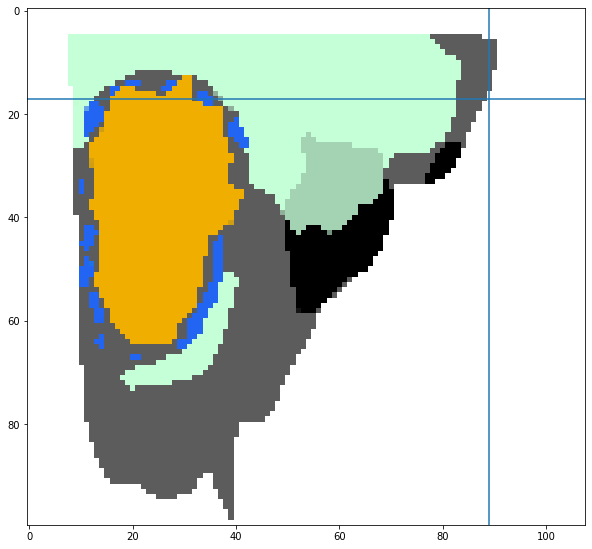

In [14]:
plt.imshow(test)
plt.axvline(89)
plt.axhline(17)

In [15]:
# So... how many colors are in here: 116 colors. So... that's the problem! 
len(cvfunc.get_colors(test)[0])

NameError: name 'cvfunc' is not defined

In [64]:
# # this is Y,X: 
# test[17][89]

In [55]:
color_list = [
    [255,255,255],
    [234,173,75],
    [202,253,224],
    [168,209,185],
    [92,92,92],
    [0,0,0],
    [56,109,226]    
]

In [89]:
for file in glob.glob(scaled_images_path+"/col*/*.png"):
    print(file)
    test = cv2.imread(file)
    print(len(cvfunc.get_colors(test)[0]))
    print('---')


/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day170_21September2021_W.png
9
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day190_11October2021_W.png
10
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day200_21October2021_E.png
10
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day159_10September2021_E.png
8
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day221_11November2021_W.png
10
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col62/col62_day170_21September2021_E.png
10
---
/Users/mich

6
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day81_24June2021_W.png
10
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day20_24apr2021_W.png
10
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day141_23August2021_E.png
5
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day81_24June2021_E.png
11
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day120_02August2021_W.png
6
---
/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day100_13July2021_W.png
7
---
/Users/michaelsmith/Library/Clo